In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [49]:
# Replace with your actual CSV path
df = pd.read_csv('train_dataset.csv')
df.head()


,image_path,class
0,archive/Train/Basophil/20190527_113105_0.jpg,Basophil
1,archive/Train/Basophil/20190531_110612_0.jpg,Basophil
2,archive/Train/Basophil/20190531_113249_0.jpg,Basophil
3,archive/Train/Basophil/20190527_111443_0.jpg,Basophil
4,archive/Train/Basophil/20190531_112055_0.jpg,Basophil


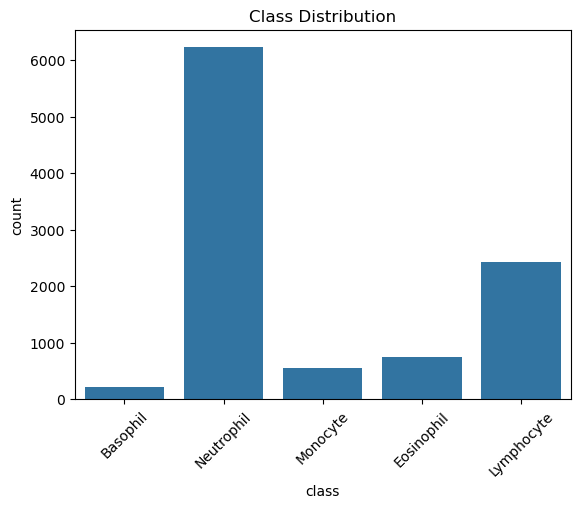

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['class'])

# One-hot encode for training
labels = to_categorical(df['label_encoded'])

# Plot class distribution
sns.countplot(x='class', data=df)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()


In [51]:
image_size = (128, 128)
X = []

for path in df['image_path']:
    img = load_img(path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # normalize
    X.append(img_array)

X = np.array(X)


In [52]:
X.shape

(10175, 128, 128, 3)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)


In [54]:
X_train.shape

(8140, 128, 128, 3)

In [55]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))  # 5 classes


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [57]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 175ms/step - accuracy: 0.7121 - loss: 0.8029 - val_accuracy: 0.9155 - val_loss: 0.2718
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.8940 - loss: 0.2890 - val_accuracy: 0.8929 - val_loss: 0.2842
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.9180 - loss: 0.2276 - val_accuracy: 0.9115 - val_loss: 0.2436
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.9243 - loss: 0.2086 - val_accuracy: 0.9514 - val_loss: 0.1572
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9485 - loss: 0.1515 - val_accuracy: 0.9489 - val_loss: 0.1537
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9519 - loss: 0.1309 - val_accuracy: 0.9518 - val_loss: 0.1471
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9634 - loss: 0.1042 - val_accuracy: 0.9440 - val_loss: 0.1660
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9662 - loss: 0

In [58]:
# creating the Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_layer = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', name="last_conv")(x)  # named for Grad-CAM
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(5, activation='softmax')(x)  # 5 classes

model_func = Model(inputs=input_layer, outputs=output_layer)


In [59]:
model_func.set_weights(model.get_weights())  # Load weights from your Sequential model

### Testing phase

In [60]:
test_df = pd.read_csv("image_dataset.csv")  # path to your test CSV

# Encode labels to match training
test_df['label_encoded'] = label_encoder.transform(test_df['class'])
test_labels = to_categorical(test_df['label_encoded'])

# Load test images
X_test = []

for path in test_df['image_path']:
    img = load_img(path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    X_test.append(img_array)

X_test = np.array(X_test)


In [61]:
test_loss, test_accuracy = model.evaluate(X_test, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9605 - loss: 0.1513
Test Accuracy: 0.94


In [62]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(test_labels, axis=1)


136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step


<Figure size 800x600 with 0 Axes>

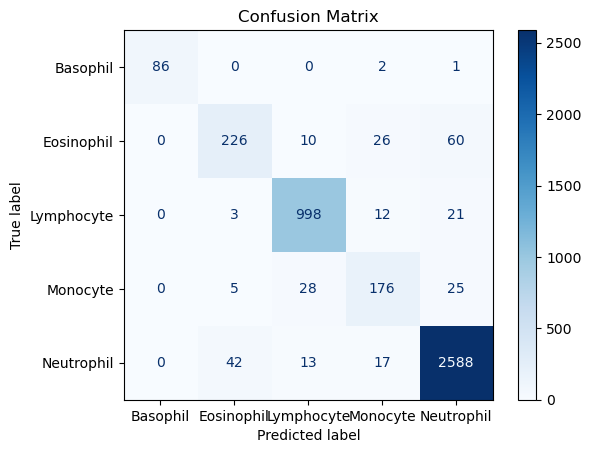

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


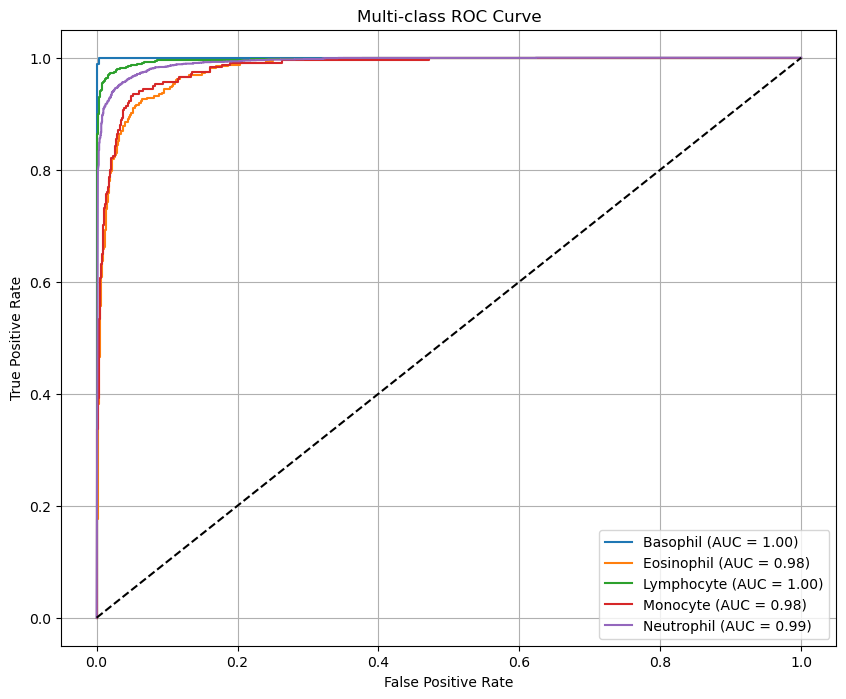

In [64]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Already one-hot encoded, so this is just for labeling
y_true_bin = test_labels
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


### saving the model

In [65]:
model.save("leukocyte_classifier.h5")


In [66]:
# Map predictions to class names
predicted_classes = label_encoder.inverse_transform(y_pred)
true_classes = label_encoder.inverse_transform(y_true)

# Create a DataFrame
results_df = pd.DataFrame({
    'image_path': test_df['image_path'],
    'true_label': true_classes,
    'predicted_label': predicted_classes
})

# Save to CSV
results_df.to_csv('leukocyte_predictions.csv', index=False)


In [67]:
_ = model.predict(np.expand_dims(X_test[0], axis=0))  # build model by calling it once


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [68]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,915,857 (37.83 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,610,572 (25.22 MB)

In [1]:
img_index = 1  # Choose test image index
img_array = np.expand_dims(X_test[img_index], axis=0)

# Use the named last conv layer
last_conv_layer_name = "last_conv"

grad_model = Model(
    inputs=model_func.input,
    outputs=[model_func.get_layer(last_conv_layer_name).output, model_func.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]

grads = tape.gradient(class_channel, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()


NameError: name 'np' is not defined

In [2]:
original_img = (X_test[img_index] * 255).astype("uint8")
heatmap_resized = cv2.resize(heatmap, (128, 128))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


NameError: name 'X_test' is not defined